In [1]:
import random
import copy
import numpy as np
import json
import vl_convert as vlc
import os
from IPython.display import Image

In [2]:
def erase_files(path):

    for filename in os.listdir(path):

        file_path = os.path.join(path, filename)

        try:
            if os.path.isfile(file_path): os.remove(file_path)
        except Exception as e:
            print(f"Error deleting {file_path}: {e}")

In [3]:
def load_list(path):

    with open(path, 'r') as file:
        list = [line.strip() for line in file]

    return list

In [4]:
def render_vega(vega_dict, scale = 1):

    spec = json.dumps(vega_dict, indent = 4)

    try:
        return vlc.vegalite_to_png(vl_spec = spec, scale = scale)
    except:
        print(spec)

def text_to_vega(texts):

    vegas = []
    for text in texts:

        try: vegas.append(json.loads(text.replace("'",'"')))
        except: print("Error in text to vega conversion")

    return vegas

In [5]:
def theme():

    return  {

        "background": "white",
        "axis": {
            "labelFont": random.choice(["serif", "monospace", "sans-serif"]),
            "labelFontSize": 8,

            "titleFontSize": 8,
            "titleFontWeight": "normal",

            "grid": random.choice([True, False]),
        },
        "style": {
            "cell": {
                "stroke": "transparent"
            }
        }
    }

def generate_dataset(n_samples, path, vega_structure = True):

    erase_files(path)

    metadata = [['file_name','text']]

    plots = [{"mark": "bar", "x_type": "nominal"}, 
             {"mark": "line", "x_type": "temporal"},
             {"mark": "circle", "x_type": "quantitative"}]

    var_names = load_list("data/var_names.txt")
    nominals = load_list("data/nominals.txt")

    for i in range(n_samples):

        plot = random.choice(plots)

        x_name = var_names.pop(random.randint(0, len(var_names) - 1))
        y_name = var_names.pop(random.randint(0, len(var_names) - 1))

        var_names.append(x_name)
        var_names.append(y_name)

        p = 2.0

        x_title = x_name if random.random() < p else ""
        y_title = y_name if random.random() < p else ""

        # generation of y values

        y_scale = random.randint(1,1000)
        y_discrete = random.choice([True, False])
        y_values = [np.round(random.random() * y_scale, 2) if not y_discrete else random.randint(1,10) * y_scale for i in range(10)]

        # generation of x values 

        x_values = None

        if plot["x_type"] == "nominal":
            x_values = nominals.copy()
        elif plot["x_type"] == "temporal":
            x_values = [int(x) for x in list(np.arange(1900,2000,random.randint(1,10)) + random.randint(-100,24))]
        elif plot["x_type"] == "quantitative":
            x_scale = random.randint(1,1000)
            x_discrete = random.choice([True, False])
            x_values = [np.round(random.random() * x_scale, 2) if not x_discrete else random.randint(1,10) * x_scale for i in range(10)]

        vega_dict = {
            
            "mark": plot["mark"],
            "encoding": {
                "x": {"field": x_name, "type": plot["x_type"], "title": x_title},
                "y": {"field": y_name, "type": "quantitative", "title": y_title}
            },
            "data": {
                "values": [
                    {x_name: x_values.pop(0), y_name: random.choice(y_values)} for j in range(random.randint(2,10)) 
                ]
            },
        }

        vega_dict_copy = copy.deepcopy(vega_dict)

        if vega_dict["encoding"]["x"]["type"] == "temporal": vega_dict["encoding"]["x"]["type"] = "quantitative"
        vega_dict["config"] = theme()

        # Image rendering <-----------------------------------------

        image_data = render_vega(vega_dict, scale = 2)

        with open(path + "/" +  str(i) + ".png", "wb") as f: 
            f.write(image_data)
        
        # ----------------------------------------------------------

        if vega_dict_copy["encoding"]["x"]["title"] == "": vega_dict_copy["encoding"]["x"]["field"] = ""
        if vega_dict_copy["encoding"]["y"]["title"] == "": vega_dict_copy["encoding"]["y"]["field"] = ""

        vega_dict_copy["encoding"]["x"].pop("title")
        vega_dict_copy["encoding"]["y"].pop("title")

        for value_dict in vega_dict_copy["data"]["values"]:
            
            try:
                value_dict["x"] = value_dict.pop(x_name)
                value_dict["y"] = value_dict.pop(y_name)
            except:
                print("Error en value dict")

        vega = None

        if vega_structure:
            vega = '"' + str(vega_dict_copy) + '"'
        else:
            vega =  plot["mark"] + "|" + plot["x_type"] + "|" + x_title + "|" + "quantitative" + "|" + y_title

        metadata.append([str(i) + ".png", vega])

    np.savetxt(path + "/metadata.csv", metadata, delimiter = ',', fmt = '% s')

In [6]:
random.seed(42)
np.random.seed(42)

dataset_name = "visdecode_simple"

generate_dataset(n_samples = 1000, path = "datasets/" + dataset_name + "/train", vega_structure = False)
generate_dataset(n_samples = 100, path = "datasets/" + dataset_name + "/test", vega_structure = False)
generate_dataset(n_samples = 20, path = "datasets/" + dataset_name + "/val", vega_structure = False)

In [7]:
from datasets import load_dataset

dataset = load_dataset("imagefolder", data_dir = "datasets/" + dataset_name)
dataset.push_to_hub("martinsinnona/" + dataset_name)

Resolving data files:   0%|          | 0/1001 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/21 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/101 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/531 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/martinsinnona/visdecode_simple/commit/92a2a2241f9bf20191b4c98cfe0b209f5c78b191', commit_message='Upload dataset', commit_description='', oid='92a2a2241f9bf20191b4c98cfe0b209f5c78b191', pr_url=None, pr_revision=None, pr_num=None)

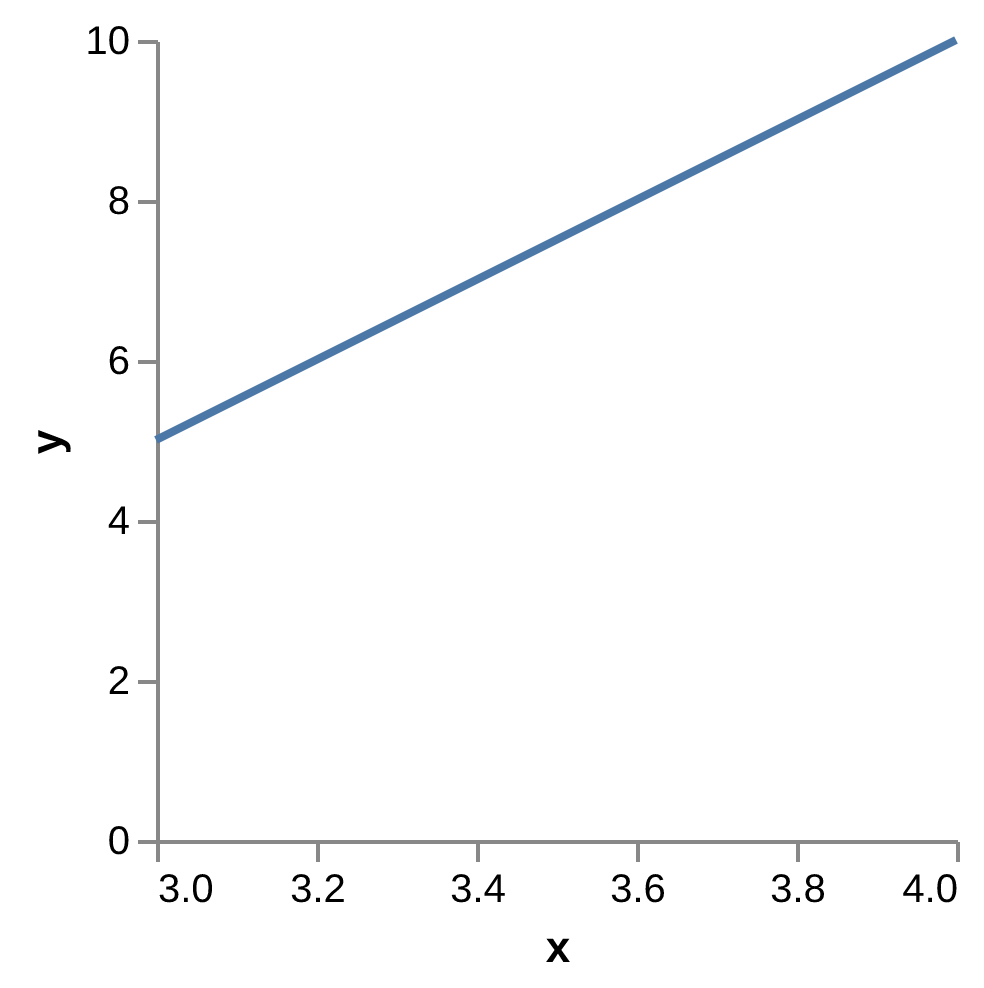

In [8]:
vega = {
            
    "mark": "line",
    "encoding": {
        "x": {"field": "x", "type": "quantitative"},
        "y": {"field": "y", "type": "quantitative"}
    },
    "data": {
        "values": [
            {"x":3, "y":5}, {"x":4, "y":10}
        ]
    },
    "config": {
        "axis": {
            "grid": False
        },
        "style": {
            "cell": {
            "stroke": "transparent"
            }
        }
    }
}

png_data = vlc.vegalite_to_png(vl_spec = vega, scale = 4)
Image(png_data, retina = True)